In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Segmentation on Kvasir-SEG

# AmirAli Amini
## 610399102
## project of AI

# Overview:
This notebook presents a comprehensive analysis and implementation of image segmentation techniques for polyp detection in gastrointestinal tract images using the Kvasir-SEG dataset. The project is divided into several phases, including dataset familiarization, preprocessing, model selection and implementation, training and validation, results and analysis, and documentation and reporting. Throughout the notebook, we explore various deep learning models and techniques to develop an effective polyp detection system, aiming to contribute to early detection and diagnosis of colorectal cancer.

## Summary:
Dataset Familiarization:

Explored the Kvasir-SEG dataset containing 1000 annotated images of polyps, along with corresponding ground truth masks.
Analyzed the structure of images and masks, and examined the JSON files for bounding box information.
Preprocessing:

Implemented image preprocessing techniques such as resizing and normalization to prepare the data for model training.
Ensured consistency in handling varying resolution images to maintain data integrity.
Model Selection and Implementation:

Researched and selected appropriate deep learning models for image segmentation, considering architectures such as U-Net and Mask R-CNN.
Implemented the "Double Encoder-Decoder Networks for Gastrointestinal Polyp Segmentation" architecture as a reference for the project.
Training and Validation:

Trained the selected model on the Kvasir-SEG dataset and validated its performance using metrics like Intersection over Union and Dice Coefficient.
Monitored the training process to ensure convergence and prevent overfitting through early stopping and model checkpointing.
Results and Analysis:

Analyzed the performance of the trained model, discussing challenges faced during training and how they were addressed.
Compared the model's performance with that of a provided research paper, highlighting similarities and differences.
Documentation and Reporting:

Documented the entire project, including steps taken, methods used, and code implementation, in Jupyter Notebook format.
Prepared a comprehensive report summarizing key findings, methodology, results, and conclusions, along with visualizations and statistical analysis.

### Define Base Path
The `basePath` variable is defined to store the base directory path where the Kvasir-SEG dataset is located.

### Define Address Function
The `address` function is defined to generate the full path of a file or directory within the dataset directory. It takes an optional `path` argument representing the relative path within the dataset directory and returns the full path by concatenating the `basePath` with the provided `path`.


# U-Net

In [2]:
from IPython.display import Image

# URL of the image
image_url = "https://www.frontiersin.org/files/Articles/841297/fnagi-14-841297-HTML-r2/image_m/fnagi-14-841297-g001.jpg"

# Display the image
Image(url=image_url)


In [3]:
basePath = "/kaggle/input/kvasir-seg/Kvasir-SEG" 
def address (path=''):
    return f"{basePath}/{path}"

### Import Necessary Libraries
The code block imports the necessary libraries for data manipulation and visualization.

- `numpy` (imported as `np`): NumPy is a library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- `pandas` (imported as `pd`): Pandas is a data manipulation library that provides data structures like DataFrame, which allows for easy handling and analysis of structured data.
- `tqdm`: TQDM is a library that provides a progress bar for iterating over iterables in Python, allowing for easy tracking of the progress of loops or operations.
- `os`: The `os` module provides functions for interacting with the operating system, such as accessing file paths, directories, and environment variables.


In [4]:
# Importing necessary libraries for data manipulation and visualization
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import os


### Set Directory Paths
The code block sets directory paths for the images and masks within the Kvasir-SEG dataset.

- `mainDirPath`: The variable `mainDirPath` stores the main directory path obtained from the `address` function, representing the root directory of the Kvasir-SEG dataset.

- `imagesPath`: The variable `imagesPath` is defined to store the path to the directory containing the images within the dataset. It is obtained by concatenating the `mainDirPath` with the relative path to the images directory.

- `masksPath`: The variable `masksPath` is defined to store the path to the directory containing the masks within the dataset. It is obtained by concatenating the `mainDirPath` with the relative path to the masks directory.


In [5]:
# Get the main directory path from the user
mainDirPath = address()

# Define the path for the directory containing images
imagesPath = mainDirPath + "/images"

# Define the path for the directory containing masks
masksPath = mainDirPath + "/masks"


### Count Images and Masks
The code block prints the total number of images and masks present in their respective directories within the Kvasir-SEG dataset.

- `os.listdir(imagesPath)`: This function retrieves the list of files and directories within the `imagesPath` directory, representing the images in the dataset.
  
- `os.listdir(masksPath)`: Similarly, this function retrieves the list of files and directories within the `masksPath` directory, representing the masks in the dataset.

- `len(...)`: The `len` function is used to calculate the length of the lists obtained, representing the total number of images and masks, respectively.

- `print(...)`: Finally, the total number of images and masks are printed using formatted strings.


In [6]:
# Print the total number of images and masks present in their respective directories
print(f"Total images: {len(os.listdir(imagesPath))}\nTotal masks: {len(os.listdir(masksPath))}")

Total images: 1001
Total masks: 1000


### Import TensorFlow and Keras
The code block imports TensorFlow and necessary modules from Keras for building and training convolutional neural networks (CNNs).

- `tensorflow` (imported as `tf`): TensorFlow is an open-source deep learning library developed by Google. It provides a comprehensive ecosystem of tools, libraries, and community resources for building and deploying machine learning models.

- `keras.models`, `keras.layers`: These modules from Keras provide high-level APIs for building neural network models. They include classes and functions for defining layers, models, and input/output operations.

### Additional Image Processing and Visualization Imports
The code block also imports additional libraries for image processing and visualization.

- `skimage.color.rgb2gray`: This function from the scikit-image library converts RGB images to grayscale.
- `skimage.io.imread`, `skimage.io.imshow`: These functions are used for reading and displaying images, respectively, from the scikit-image library.
- `skimage.transform.resize`: This function resizes images to a specified shape.
- `matplotlib.pyplot`: This library is used for creating visualizations and plots.
- `skimage.morphology.label`: This function is used for labeling connected components in an image.
- `PIL.Image`: This module from the Python Imaging Library (PIL) provides support for opening, manipulating, and saving many different image file formats.


In [7]:
# Important imports
# Important imports for building and training convolutional neural networks using TensorFlow and Keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
import os

# Additional imports for image processing and visualization
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label
from PIL import Image

2024-02-09 18:30:04.990662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 18:30:04.990823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 18:30:05.244240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Plot Training History
The `plot_training` function is defined to visualize the training history of a neural network model. It plots the training and validation accuracy and loss over epochs, highlighting the epochs with the best validation accuracy and lowest validation loss.

- **Parameters:**
  - `hist`: The training history object containing metrics such as accuracy and loss.

- **Functionality:**
  - The function extracts the training and validation accuracy (`tr_acc`, `val_acc`) and loss (`tr_loss`, `val_loss`) from the history object.
  - It finds the index of the epoch with the lowest validation loss (`index_loss`) and the index of the epoch with the highest validation accuracy (`index_acc`).
  - It creates a list of epochs (`Epochs`) for plotting.
  - It sets labels for highlighting the best epochs in the plots.
  - It sets a new style for the plots using `plt.style.use('seaborn-dark')`.
  - It plots the training and validation loss and accuracy using `matplotlib.pyplot`.

- **Example Usage:**
  - After training a model and obtaining a history object `hist`, you can call the function `plot_training(hist)` to visualize the training history.

This function provides insights into the training progress of a neural network model, helping to analyze its performance and identify the best epochs based on validation metrics.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    '''
    This function takes a training history object and plots the history of accuracy and losses, 
    highlighting the best epoch in both of them.
    
    Parameters:
    hist (history object): The training history object containing metrics such as accuracy and loss.
    '''

    # Extracting necessary variables from the history object
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    # Finding the index of the epoch with the lowest validation loss
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    
    # Finding the index of the epoch with the highest validation accuracy
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    # Generating a list of epochs
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Creating labels for highlighting best epochs in the plots
    loss_label = f'Best epoch= {str(index_loss + 1)}'
    acc_label = f'Best epoch= {str(index_acc + 1)}'

    # Setting a new style for the plots
    plt.style.use('seaborn-dark')

    # Plotting Training Loss
    plt.figure(figsize=(8, 6))
    plt.plot(Epochs, tr_loss, 'orange', label='Training loss')
    plt.plot(Epochs[index_loss], val_loss[index_loss], marker='o', markersize=8, color="red", label=loss_label)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(Epochs, val_loss, 'blue', label='Validation loss')
    plt.plot(Epochs[index_loss], val_loss[index_loss], marker='o', markersize=8, color="red", label=loss_label)
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Training Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(Epochs, tr_acc, 'orange', label='Training Accuracy')
    plt.plot(Epochs[index_acc], val_acc[index_acc], marker='o', markersize=8, color="red", label=acc_label)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(Epochs, val_acc, 'blue', label='Validation Accuracy')
    plt.plot(Epochs[index_acc], val_acc[index_acc], marker='o', markersize=8, color="red", label=acc_label)
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming hist is your history object
# plot_training(hist)


### Prepare Data Arrays
The code block prepares numpy arrays to store image and mask data.

- **Get List of Filenames:**
  - `images_ids`: Obtains the list of filenames in the `imagesPath` directory using `os.walk` and `next` functions.
  - `masks_ids`: Obtains the list of filenames in the `masksPath` directory using similar methods.

- **Initialize Image and Mask Arrays:**
  - `X`: Initializes an empty numpy array `X` to hold the image data. It has a shape of `(number of images, 256, 256, 3)` where each image has a size of 256x256 pixels with 3 channels (RGB). The data type is set to unsigned 8-bit integers (`np.uint8`).
  - `Y`: Initializes an empty numpy array `Y` to hold the mask data. It has a shape of `(number of masks, 256, 256, 1)` where each mask has a size of 256x256 pixels with 1 channel (binary mask). The data type is set to boolean (`np.bool_`).


In [9]:
# Get the list of filenames in the 'imagesPath' directory
images_ids = next(os.walk(imagesPath))[2]

# Get the list of filenames in the 'masksPath' directory
masks_ids = next(os.walk(masksPath))[2]

# Initialize an empty numpy array 'X' to hold the image data.
# The shape of 'X' will be (number of images, 256, 256, 3), where:
# - 'number of images' is the length of the list 'images_ids'
# - Each image will have a size of 256x256 pixels with 3 channels (RGB)
# The data type of 'X' will be unsigned 8-bit integers (0 to 255)
X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)

# Initialize an empty numpy array 'Y' to hold the mask data.
# The shape of 'Y' will be (number of masks, 256, 256, 1), where:
# - 'number of masks' is the length of the list 'masks_ids'
# - Each mask will have a size of 256x256 pixels with 1 channel (binary mask)
# The data type of 'Y' will be boolean
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

### Resize Images and Masks
The code block resizes the training images and masks to a target size of 256x256 pixels and adds them to the previously initialized numpy arrays.

- **Iteration through Images:**
  - The code iterates through each image in the dataset using `enumerate` to track the index `n` and filename `id_`.

- **Image Processing:**
  - It constructs the full path to the current image using the `imagesPath` directory and the filename.
  - It reads the image using the `imread` function, keeping only the RGB channels.
  - It resizes the image to the desired size of 256x256 pixels while preserving the range of pixel values using `skimage.transform.resize`.
  - It assigns the resized image to the appropriate index in the `X` array.

- **Mask Processing:**
  - It initializes a mask array filled with zeros of shape `(256, 256, 1)`.
  - It reads the corresponding mask image using the `imread` function from the `masksPath`.
  - Any necessary preprocessing can be applied to the mask image (e.g., converting to grayscale).
  - The mask image is resized to the desired size of 256x256 pixels while preserving the range of pixel values using `skimage.transform.resize`.
  - The resized mask is assigned to the appropriate index in the `Y` array.


In [10]:
# Resizing the images to 256, 256 and then afdding them to the above matrix
print("Resizing training images and masks")
# Iterate through each image in the dataset
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    
    # Construct the path to the current image
    path = imagesPath + "/" + id_
    
    # Read the image using imread function, keeping only the RGB channels
    img = imread(path)[:, :, :3]
    
    # Resize the image to the desired size (256x256) while preserving the range of pixel values
    img = resize(img, (256, 256), mode="constant", preserve_range=True)
    
    # Assign the resized image to the appropriate index in the 'X' array
    X[n] = img
    X[n] = img
    
    # Initialize a mask array filled with zeros of shape (256, 256, 1)
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    
    # Read the corresponding mask image using imread function
    mask = imread(masksPath + "/" + id_)
    
    # Apply any necessary preprocessing to the mask image (e.g., converting to grayscale)
    mask = rtg(mask)
    
    # Resize the mask image to the desired size (256x256) while preserving the range of pixel values
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    # Assign the resized mask to the appropriate index in the 'Y' array
    Y[n] = mask

Resizing training images and masks


100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


### Shape of Final Matrices
The code block prints the shape of the final numpy arrays containing the training images and masks after resizing.

- `X_train.shape`: This represents the shape of the `X` array, which holds the image data. It indicates the number of images, height, width, and number of channels (RGB).
- `Y_train.shape`: This represents the shape of the `Y` array, which holds the mask data. It indicates the number of masks, height, width, and number of channels (1 for binary masks).


In [11]:
# Shape of the final matrix
print(f"X_train.shape: {X.shape}\nY_train.shape: {Y.shape}")

X_train.shape: (1000, 256, 256, 3)
Y_train.shape: (1000, 256, 256, 1)


### Plot Random Images and Masks
The code block plots a random image and its corresponding mask from the dataset.

- **Generate Random Index:**
  - It generates a random index (`image_x`) within the range of the number of images in the dataset using the `random.randint` function.

- **Display Random Image:**
  - It displays the randomly selected image from the `X` array using `imshow` function from `skimage.io`.
  
- **Display Corresponding Mask:**
  - It displays the corresponding mask for the randomly selected image from the `Y` array using `plt.imshow`. The `np.squeeze` function is used to remove single-dimensional entries from the shape of the array before plotting. The colormap `'gray'` is applied to visualize the binary mask.


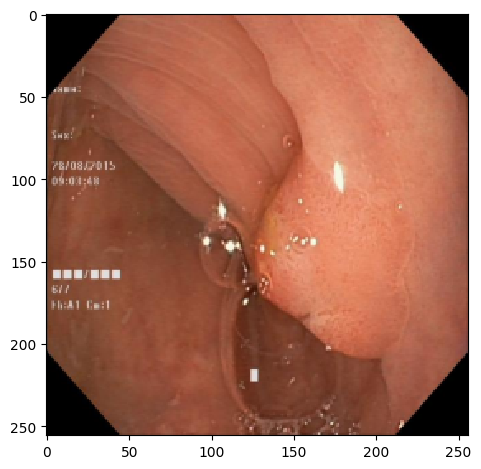

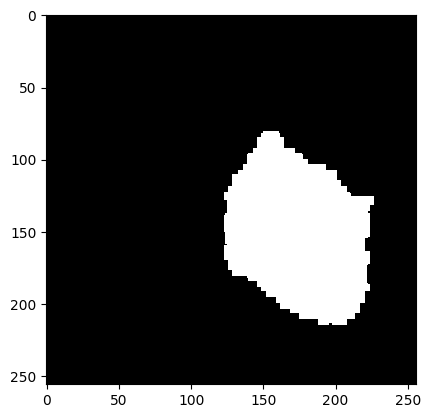

In [12]:
# Plotting random images and their mask
import random

# Generate a random index to select a random image from the dataset
image_x = random.randint(0, len(images_ids))

# Display the randomly selected image
imshow(X[image_x])
plt.show()

# Display the corresponding mask for the randomly selected image
plt.imshow(np.squeeze(Y[image_x]),cmap='gray', interpolation='nearest')

### Create Training and Validation Data
The code block creates training and validation data by splitting the dataset into two parts:

- **Training Data:**
  - `x_train`: It contains the first 900 images selected from the `X` array.
  - `y_train`: It contains the masks corresponding to the first 900 images selected from the `Y` array.

- **Validation Data:**
  - `x_val`: It contains the remaining images (after the first 900) selected from the `X` array.
  - `y_val`: It contains the masks corresponding to the remaining images selected from the `Y` array.


In [13]:
# Creating training data by selecting the first 900 images and their corresponding masks
x_train = X[:900]  # Select the first 900 images
y_train = Y[:900]  # Select the masks corresponding to the first 900 images

# Creating validation data by selecting the remaining images and their corresponding masks
x_val = X[900:]   # Select the images after the first 900
y_val = Y[900:]   # Select the masks corresponding to the images after the first 900


### Define U-Net Architecture
The code block defines the architecture of a U-Net model for image segmentation using TensorFlow and Keras.

- **Input Layer:**
  - `input`: The input layer is defined with a shape of (256, 256, 3) representing the height, width, and number of channels (RGB) of the input images.

- **Preprocessing Layer:**
  - `s`: The input data is preprocessed by dividing each pixel value by 256 using a lambda layer.

- **Contracting Path (Encoder):**
  - The contracting path consists of convolutional layers (`c1` to `c5`) followed by max-pooling layers (`p1` to `p4`). These layers progressively reduce the spatial dimensions of the input while increasing the number of channels.

- **Expansive Path (Decoder):**
  - The expansive path consists of convolutional transpose layers (`u6` to `u9`) followed by concatenation with corresponding feature maps from the contracting path and convolutional layers (`c6` to `c9`). These layers progressively upsample the feature maps to the original input size while reducing the number of channels.

- **Output Layer:**
  - `outputs`: The output layer produces the binary segmentation mask with a sigmoid activation function applied to the final convolutional layer.

- **Model Compilation:**
  - The U-Net model is compiled with the Adam optimizer and binary cross-entropy loss function.


In [14]:
import tensorflow as tf

inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x / 256)(inputs)

# Downward path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# Bottom
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Upward path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# Additional layers
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c11 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c12 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

modelUNet = tf.keras.Model(inputs=inputs, outputs=outputs, name='U-Net')

modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
modelUNet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                              

### Define Callbacks for Model Training
The code block defines callbacks to be used during model training.

- **Callbacks:**
  - `EarlyStopping`: Stops training when a monitored metric has stopped improving. The `patience` parameter specifies the number of epochs with no improvement after which training will be stopped. The `monitor` parameter specifies the metric to be monitored for improvement.
  
  - `TensorBoard`: This callback is used to visualize the model's training metrics in TensorBoard. The `log_dir` parameter specifies the directory where the log files will be written for visualization.

- **Usage:**
  - These callbacks are passed as a list to the `callbacks` parameter of the `fit` method when training the model.


In [16]:
# Defining callbacks for the model training
callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    
    # EarlyStopping callback: stops training when a monitored metric has stopped improving.
    # patience: Number of epochs with no improvement after which training will be stopped.
    # monitor: Metric to be monitored for improvement.
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    
    # TensorBoard callback: used to visualize the model's training metrics in TensorBoard.
    # log_dir: Directory where the log files will be written for visualization.
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


# results = modelUNet.fit(x_train, y_train, validation_split=0.1, batch_size=8, epochs=1, callbacks=callbacks)
# Training the model
# modelUNet: The UNet model object to be trained.
# x_train: Input data for training.
# y_train: Target data for training.
# validation_split: Fraction of the training data to be used as validation data.
# batch_size: Number of samples per gradient update.
# epochs: Number of epochs to train the model.
# callbacks: List of callbacks to be applied during training.
results = modelUNet.fit(x_train, y_train, validation_split=0.01, batch_size=4, epochs=50, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1707503506.964304     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223/223 [==============================] - 42s 101ms/step - loss: 0.4489 - accuracy: 0.8236 - val_loss: 0.3757 - val_accuracy: 0.8216
Epoch 2/50
223/223 [==============================] - 15s 66ms/step - loss: 0.3900 - accuracy: 0.8259 - val_loss: 0.3564 - val_accuracy: 0.8228
Epoch 3/50
223/223 [==============================] - 15s 67ms/step - loss: 0.3722 - accuracy: 0.8286 - val_loss: 0.3600 - val_accuracy: 0.8215
Epoch 4/50
223/223 [==============================] - 15s 68ms/step - loss: 0.3604 - accuracy: 0.8366 - val_loss: 0.3329 - val_accuracy: 0.8499
Epoch 5/50
223/223 [==============================] - 15s 68ms/step - loss: 0.3623 - accuracy: 0.8361 - val_loss: 0.3262 - val_accuracy: 0.8628
Epoch 6/50
223/223 [==============================] - 15s 69ms/step - loss: 0.3507 - accuracy: 0.8447 - val_loss: 0.3280 - val_accuracy: 0.8527
Epoch 7/50
223/223 [==============================] - 16s 70ms/step - loss: 0.3499 - accuracy: 0.8452 - val_loss: 0.3271 - val_accuracy: 0.8700
Ep

/tmp/ipykernel_34/2536288201.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


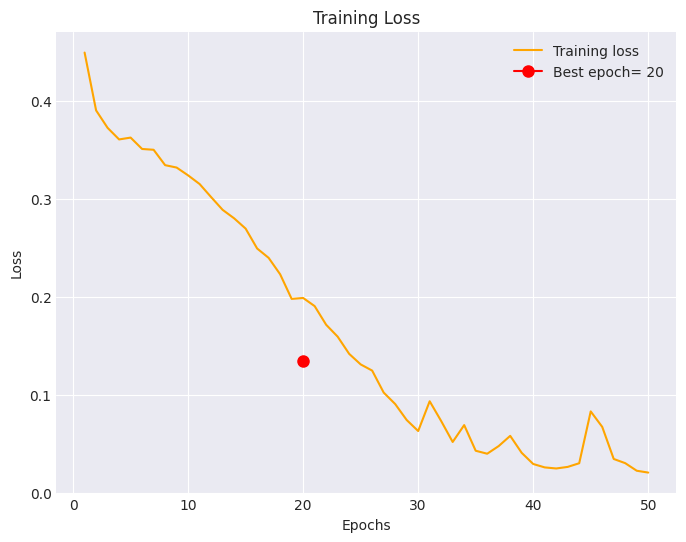

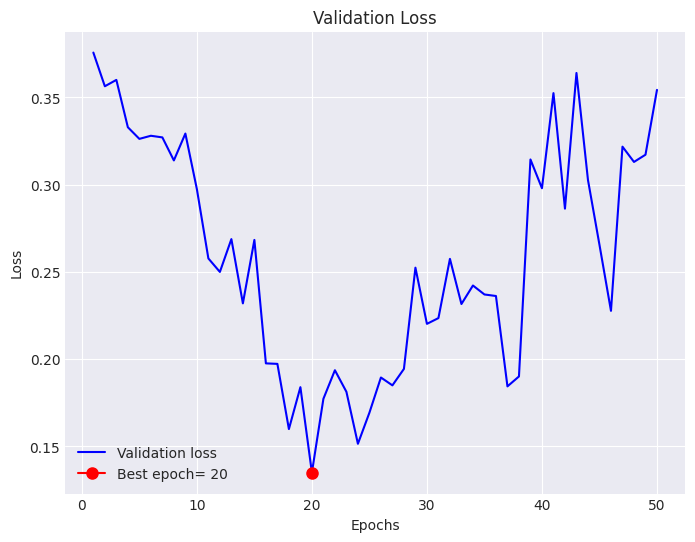

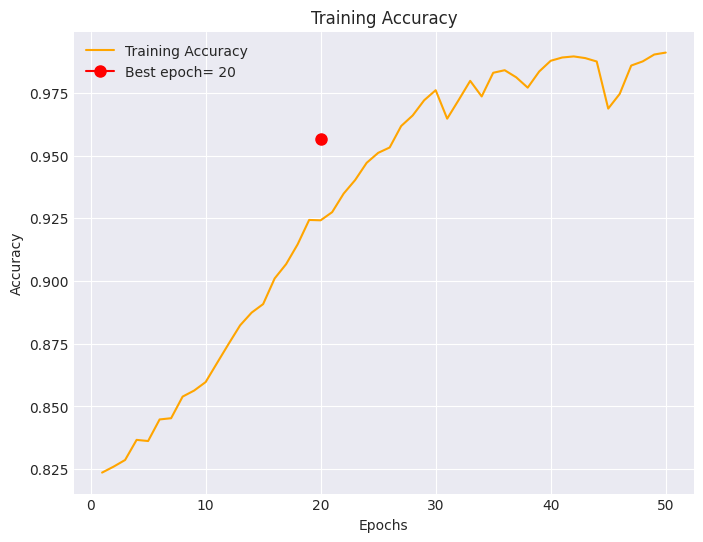

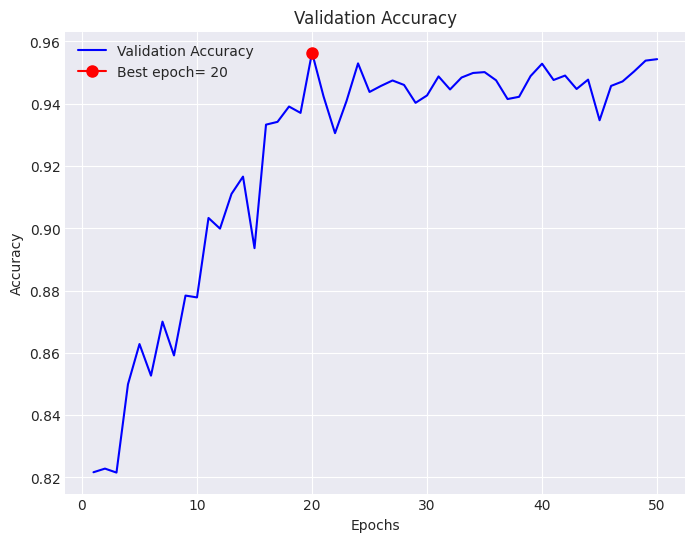

In [17]:
plot_training(results)

In [18]:
modelUNet.evaluate(X, Y)

32/32 [==============================] - 18s 239ms/step - loss: 0.0700 - accuracy: 0.9839


[0.07002752274274826, 0.9839336276054382]

### Visualize Predicted Masks
The code block visualizes predicted masks for a random selection of images from the validation data using the trained U-Net model.

- **For Each Iteration:**
  - It selects a random index within the range of the validation data.
  - It fetches the image corresponding to the random index from the validation data (`x_val`).
  - It uses the trained U-Net model (`modelUNet`) to predict the mask for the selected image.
  - It creates a new figure for visualization with a size of (15, 5).
  - It adds subplots for the original image, original mask, and predicted mask.
    - The original image is displayed in the first subplot (`ax1`).
    - The original mask is displayed in the second subplot with grayscale colormap (`ax2`).
    - The predicted mask is displayed in the third subplot (`ax3`) using the `jet` colormap and nearest interpolation method. You can adjust the colormap and interpolation method as needed.
  - It hides the axis for a cleaner look in all subplots.

- **Displaying the Plots:**
  - After iterating through the selected number of images, it displays all the plots together.


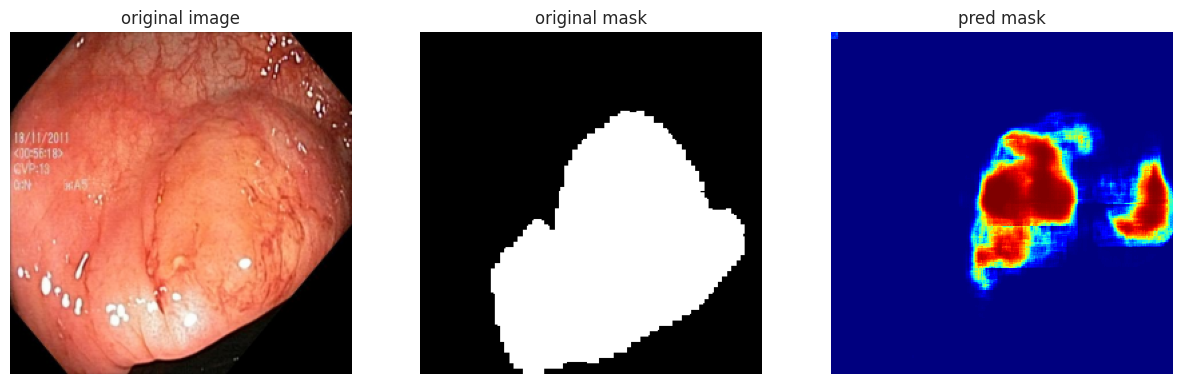

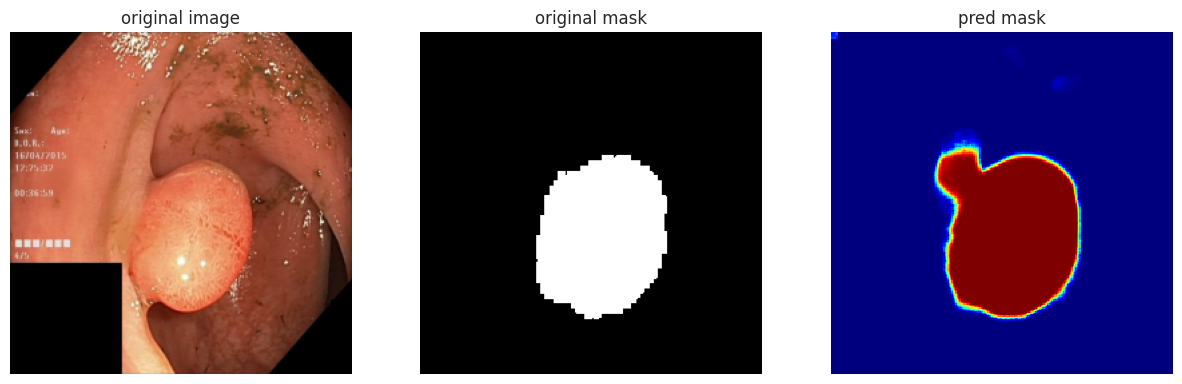

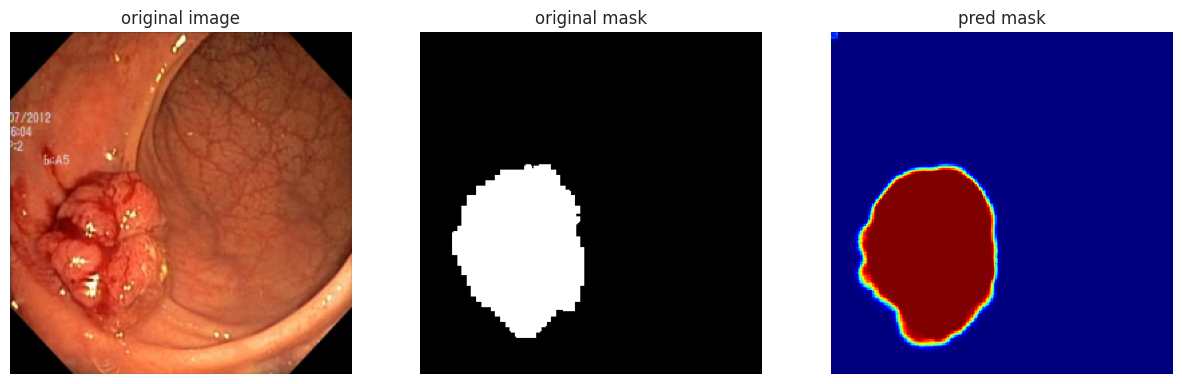

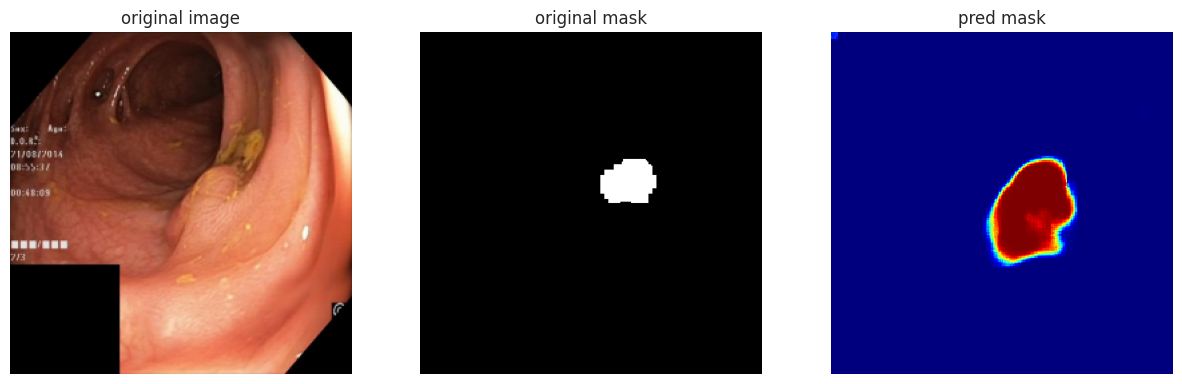

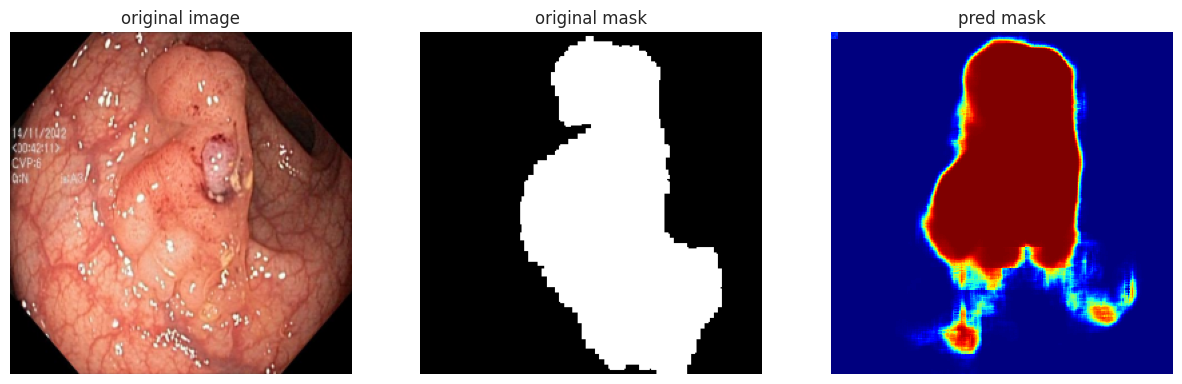

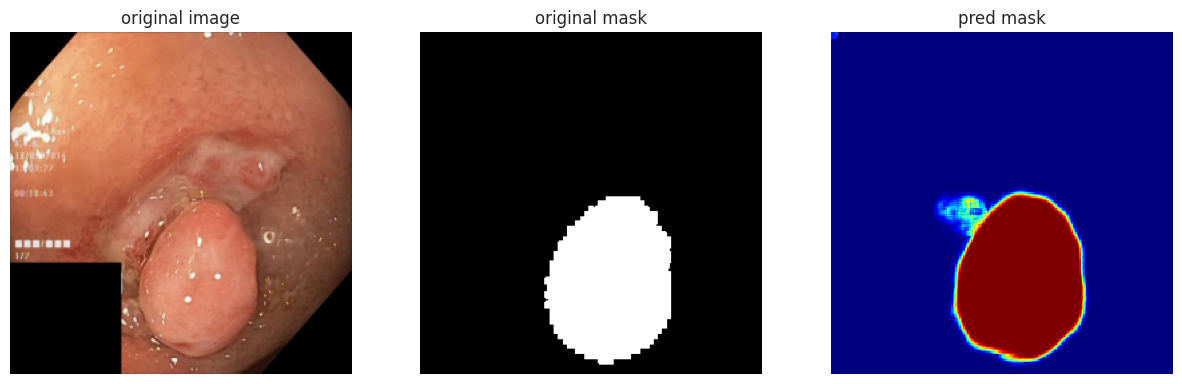

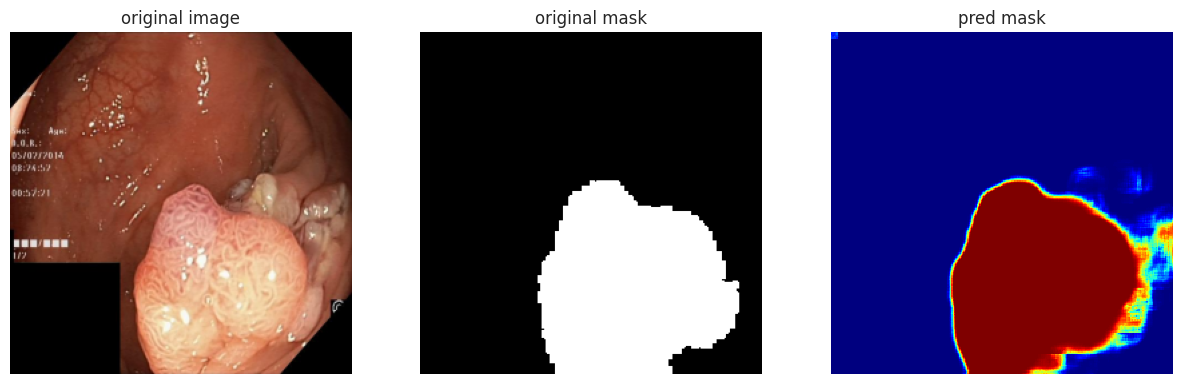

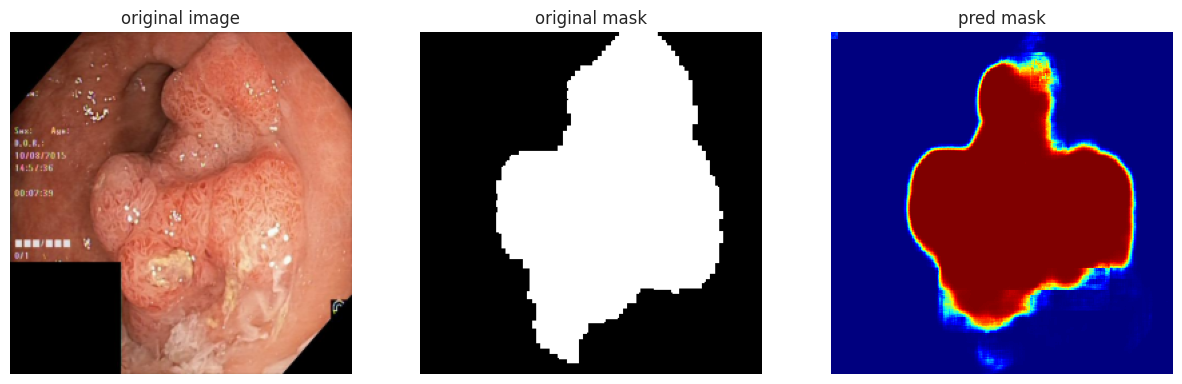

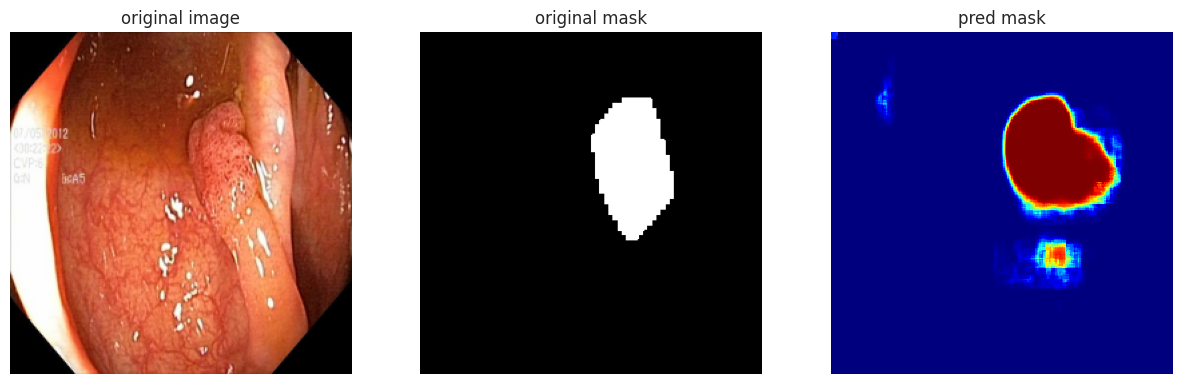

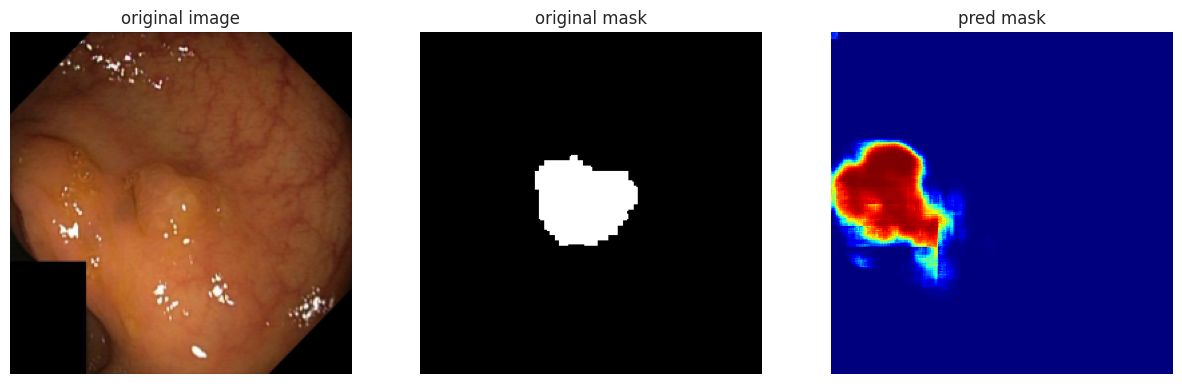

In [19]:
import matplotlib.pyplot as plt
for i in range(10):
    # Selecting a random index within the range of the validation data
    ind = random.randint(0, len(x_val))
    
    # Fetching the image corresponding to the random index
    img = x_val[ind]
    
    # Using the trained model to predict the mask for the selected image
    predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
    
    # Creating a new figure for visualization
    fig = plt.figure(figsize=(15, 5))  # Adjust figsize as needed
    
    # Adding subplots for original image, original mask, and predicted mask
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title("original image")
    ax1.imshow(x_val[ind])
    ax1.axis('off')  # Hide axis for cleaner look
    
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title("original mask")
    ax2.imshow(np.squeeze(y_val[ind]), cmap='gray')   # Displaying the original mask with grayscale colormap
    ax2.axis('off')  # Hide axis

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title("pred mask")
    ax3.imshow(np.squeeze(predMask), cmap='jet', interpolation='nearest')  # Adjust the colormap and interpolation method as needed
    ax3.axis('off')  # Hide axis
# Displaying the plots
plt.show()



In [22]:

import numpy as np  # Importing NumPy for numerical operations
from sklearn.metrics import confusion_matrix  # Importing confusion_matrix from scikit-learn for computing confusion matrices
import seaborn as sns  # Importing seaborn for statistical data visualization
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting

# This code snippet imports the necessary libraries for numerical operations, computing confusion matrices, and visualization.


4/4 [==============================] - 0s 150ms/step
Confusion Matrix:
[[5265142.  222050.]
 [ 317993.  748415.]]


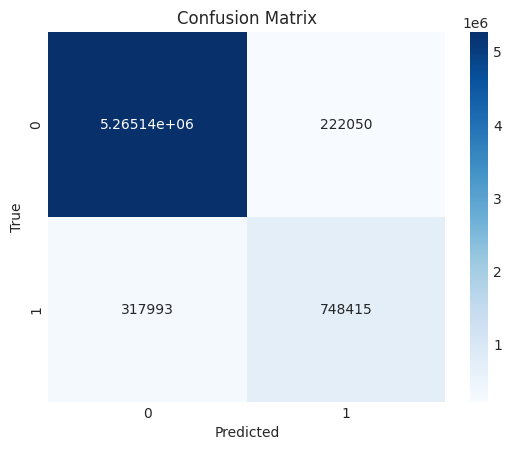

In [21]:

predictions = modelUNet.predict(x_val)  

# Convert predictions and ground truth masks to binary masks
predicted_masks = (predictions > 0.5).astype(np.uint8)
true_masks = y_val.astype(np.uint8)  

# Flatten masks
predicted_masks_flat = predicted_masks.reshape(-1)
true_masks_flat = true_masks.reshape(-1)

# Compute confusion matrix
conf_matrix = np.zeros((2, 2))
for i in range(2):  # 2 classes: background and foreground
    for j in range(2):
        conf_matrix[i, j] = np.sum((true_masks_flat == i) & (predicted_masks_flat == j))

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Precision, Recall, and F1-score Calculation and Visualization

This code block calculates precision, recall, and F1-score for each class (foreground and background) based on a confusion matrix (`conf_matrix`). These metrics are commonly used to evaluate the performance of classification models.

#### Precision
Precision is the ratio of true positives to the sum of true positives and false positives. It indicates the proportion of correctly predicted positive cases out of all predicted positive cases.

#### Recall
Recall, also known as sensitivity, is the ratio of true positives to the sum of true positives and false negatives. It measures the proportion of actual positive cases that were correctly identified by the model.

#### F1-score
The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A high F1-score indicates that the model has good precision and recall simultaneously.

### Code Explanation
- The precision, recall, and F1-score are calculated for each class using the formulas mentioned above.
- The calculated metrics are then plotted using matplotlib to visualize the performance of the model for each class.


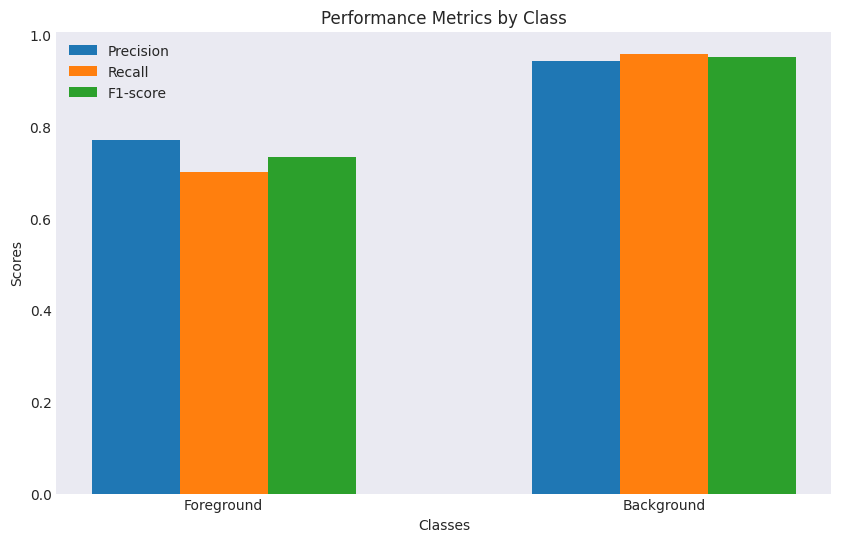

In [23]:

# Calculate precision, recall, and F1-score for each class
# Precision: true positives / (true positives + false positives)
# Recall: true positives / (true positives + false negatives)
# F1-score: harmonic mean of precision and recall
import matplotlib.pyplot as plt

# Calculate precision, recall, and F1-score for each class
precision = [conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]), conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])]
recall = [conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]), conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])]
f1_score = [2 * (precision[0] * recall[0]) / (precision[0] + recall[0]), 2 * (precision[1] * recall[1]) / (precision[1] + recall[1])]

# Plotting
classes = ['Foreground', 'Background']
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1_score]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = range(len(classes))

for i in range(len(metrics)):
    ax.bar([x + bar_width * i for x in index], values[i], bar_width, label=metrics[i])

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Class')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(classes)
ax.legend()

plt.show()


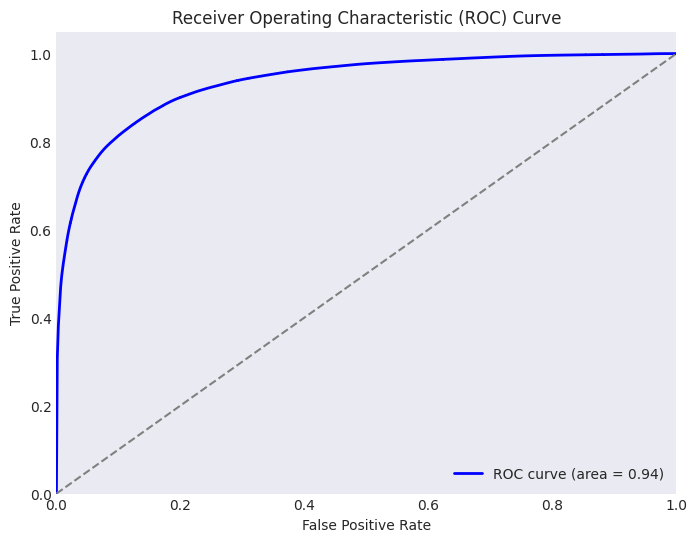

In [24]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_masks_flat, predictions.flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


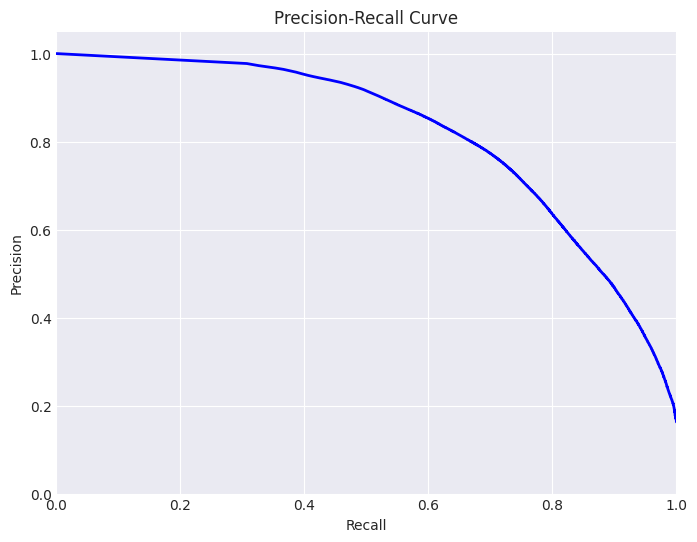

In [25]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_masks_flat, predictions.flatten())

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


/tmp/ipykernel_34/2539291992.py:10: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.sum((true_masks_flat == 1) & (predicted_masks_flat_thresholded == 1)) / np.sum(predicted_masks_flat_thresholded == 1)


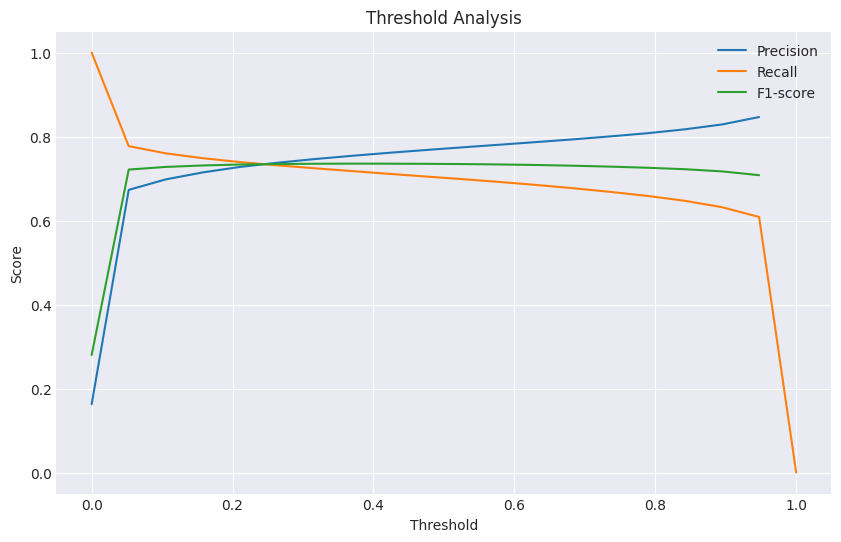

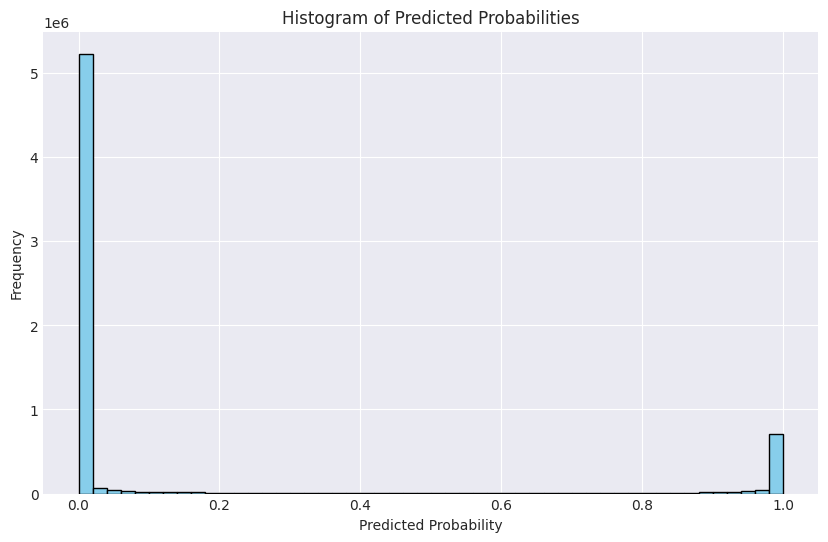

In [26]:
# Calculate precision, recall, and F1-score for different thresholds
threshold_values = np.linspace(0, 1, 20)
precision_values = []
recall_values = []
f1_score_values = []

for threshold in threshold_values:
    predicted_masks_thresholded = (predictions > threshold).astype(np.uint8)
    predicted_masks_flat_thresholded = predicted_masks_thresholded.reshape(-1)
    precision = np.sum((true_masks_flat == 1) & (predicted_masks_flat_thresholded == 1)) / np.sum(predicted_masks_flat_thresholded == 1)
    recall = np.sum((true_masks_flat == 1) & (predicted_masks_flat_thresholded == 1)) / np.sum(true_masks_flat == 1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)

# Plot precision, recall, and F1-score vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_values, label='Precision')
plt.plot(threshold_values, recall_values, label='Recall')
plt.plot(threshold_values, f1_score_values, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()
# Plot histograms of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predictions.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


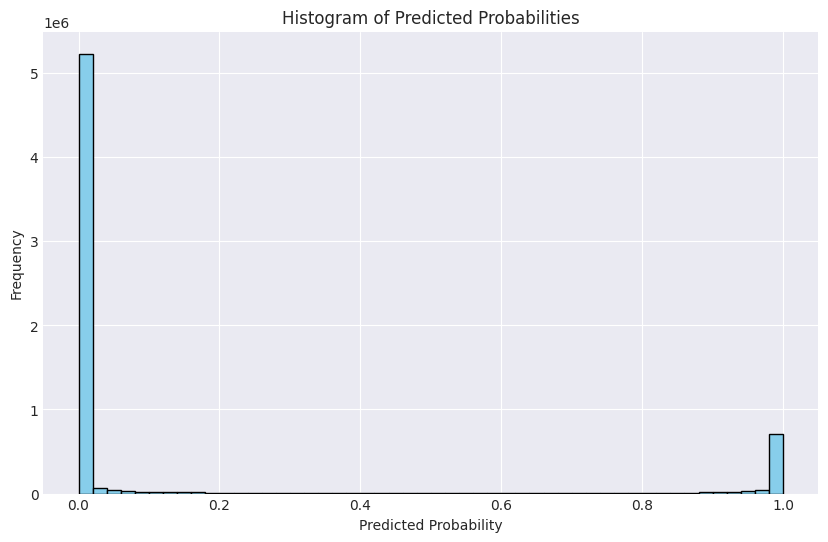

In [27]:
# Plot histograms of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predictions.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()
